In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [3]:
path_base = '../data/Haniffa/'
path_filtered = path_base + '01_bcrs_filtered.h5ad'
path_anno = path_base + '02_bcrs_annoated.h5ad'

## Merge Data

In [4]:
samples = ['Asymptomatic', 'Critical', 'Healthy', 'Mild', 'Moderate', 'Severe']
adatas = []

for name in samples:
    path_file = f'{path_base}B_cells/BCR_{name}.h5ad'
    adata_tmp = sc.read(path_file)
    adatas.append(adata_tmp)
    
adata = adatas[0].concatenate(adatas[1:])

## Filter based on BCR

In [5]:
print(np.sum(adata.obs['junction_aa_heavy'].isna()))
print(np.sum(adata.obs['junction_aa_light'].isna()))

0
0


In [6]:
def is_valid_seq(seq):
    aas = 'ACDEFGHIKLMNPQRSTVWY'
    for let in seq:
        if let not in aas:
            return False
    return True

In [7]:
print('All cells: ', len(adata))
adata = adata[adata.obs['vdj_status']=='Single']
print('With single IR: ', len(adata))
adata = adata[adata.obs['junction_aa_light'].apply(lambda x: is_valid_seq(x)).tolist()]
print('With valid light: ', len(adata))
adata = adata[adata.obs['junction_aa_heavy'].apply(lambda x: is_valid_seq(x)).tolist()]
print('And with valid heavy: ', len(adata))
adata = adata[adata.obs['junction_aa_heavy'].apply(lambda x: len(x))<=30]
print('Without long Heavy: ', len(adata))

All cells:  40720
With single IR:  39307
With valid light:  39028
And with valid heavy:  38936
Without long Heavy:  38793


In [8]:
adata.obs['celltype_B'].value_counts()

B_naive                  21984
B_switched_memory         3320
B_immature                2988
Plasmablast               2811
Plasma_cell_IgG           2330
Plasma_cell_IgA           1962
B_exhausted               1447
B_non-switched_memory     1426
Plasma_cell_IgM            525
Name: celltype_B, dtype: int64

# Highly Var Selection

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
print('Shape before: ', adata.shape)
adata = adata[:, adata.var['highly_variable']]
print('Shape after: ', adata.shape)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
C:\Users\felix.drost\Anaconda3\envs\mvtcr_4\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:01)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Shape before:  (38793, 31279)
Shape after:  (38793, 5000)


In [10]:
sc.write(adata=adata, filename=path_filtered)

C:\Users\felix.drost\Anaconda3\envs\mvtcr_4\lib\site-packages\anndata\_core\anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'patient_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Ethnicity' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Swab_result' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Status' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Smoker' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Status_on_day_collection' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Status_on_day_collection_summary' as categorical
Trying t

## Model Specific Preproccessing


In [11]:
adata = sc.read(path_filtered)

### Clonotype Annotation

In [12]:
adata.obs['VJ+VDJ'] = adata.obs['junction_aa_light'].astype(str) + '+' + adata.obs['junction_aa_heavy'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['VJ+VDJ'].unique())}
adata.obs['clonotype'] = adata.obs['VJ+VDJ'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

36447


BGCV02_AAAGCAATCACGGTTA-1-0    0
BGCV02_AAATGCCCAGGGATTG-1-0    1
BGCV02_AACCATGTCATGTGGT-1-0    2
BGCV02_AACTCCCCAGCGATCC-1-0    3
BGCV02_AACTTTCCAGCTGTTA-1-0    4
Name: clonotype, dtype: int64

### Embed Proteins

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [13]:
import sys
sys.path.append('../')
import tcr_embedding.utils_preprocessing as utils

In [14]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
adata.uns['aa_to_id'] = aa_to_id

In [15]:
alpha_length = adata.obs['junction_aa_light'].apply(lambda x: len(x)).max()
beta_length = adata.obs['junction_aa_heavy'].apply(lambda x: len(x)).max()

max_length = max(alpha_length, beta_length)
max_length

30

In [16]:
type(max_length)

numpy.int64

In [17]:
utils.aa_encoding(adata, read_col='junction_aa_light', label_col='alpha_seq', length_col='alpha_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='junction_aa_heavy', label_col='beta_seq', length_col='beta_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)

In [18]:
adata.obsm['alpha_seq'].shape

(38793, 30)

In [19]:
adata.obsm['beta_seq'].shape

(38793, 30)

In [20]:
adata.write_h5ad(path_anno)

... storing 'VJ+VDJ' as categorical


# Umap

In [21]:
metadata = [
    'initial_clustering',
    'Sex',
    'Age',
    'Ethnicity',
    'Swab_result',
    'Status',
    'Smoker',
    'Status_on_day_collection_summary',
    'Status_3_days_post_collection',
    'Status_7_days_post_collection',
    'Days_from_onset',
    'Site',
    'Worst_Clinical_Status',
    'Outcome',
    'celltype_B_v2',
]

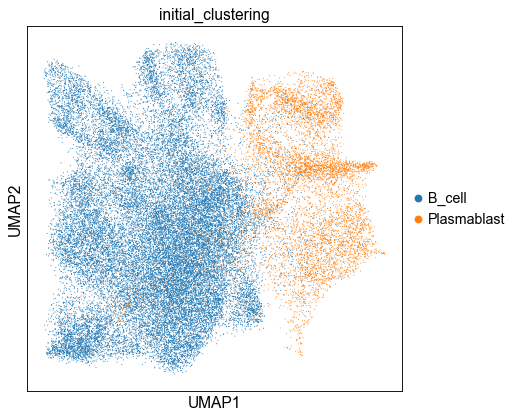

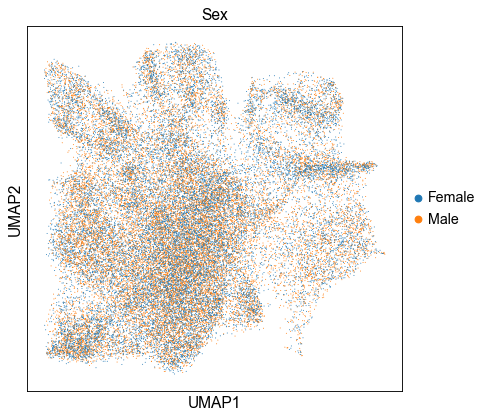

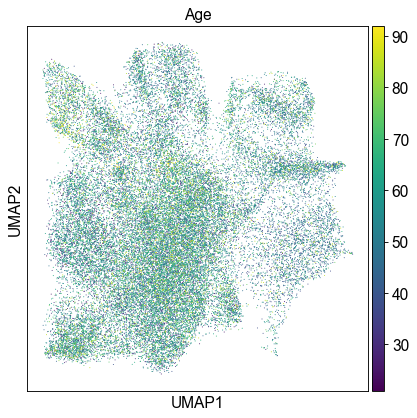

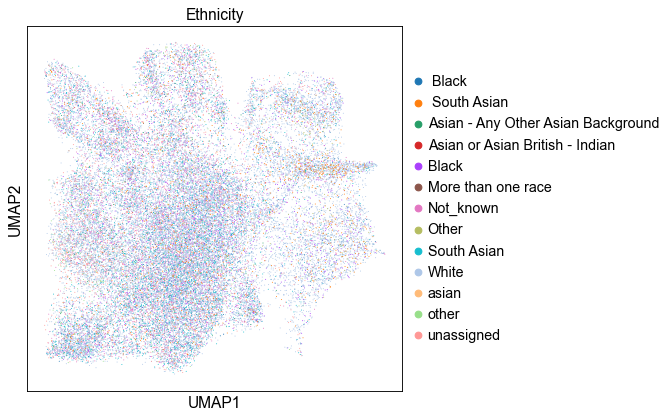

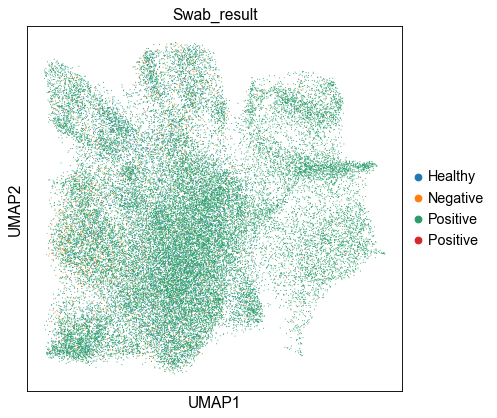

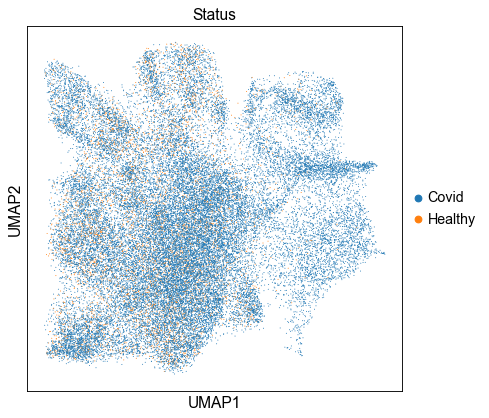

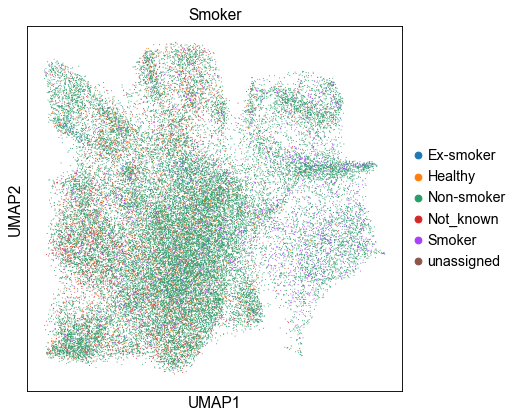

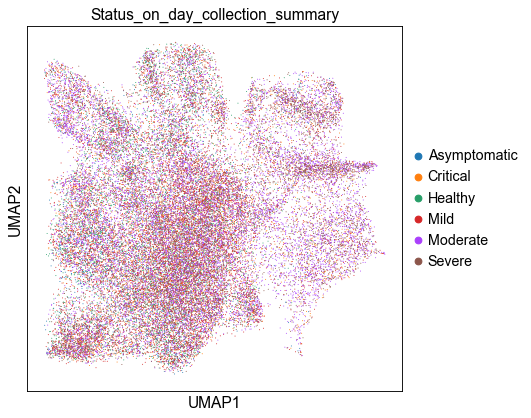

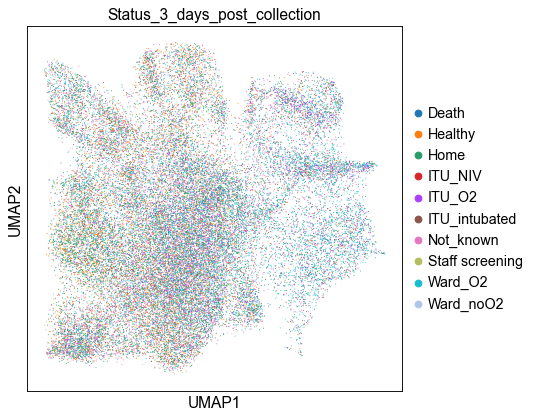

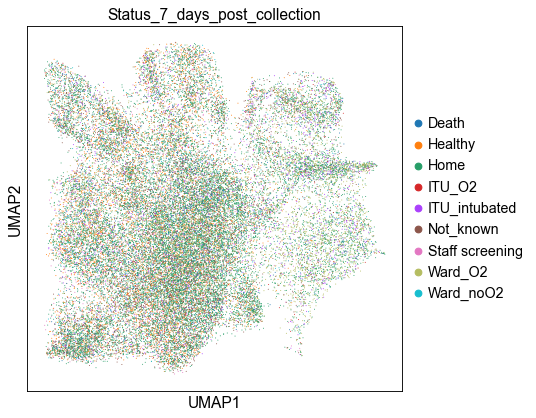

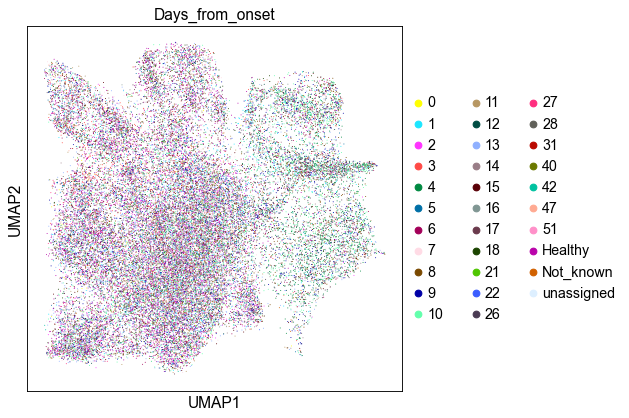

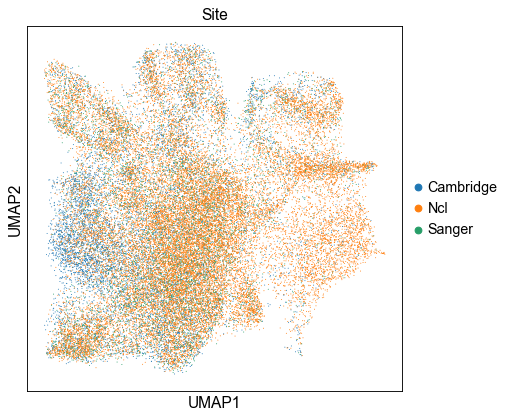

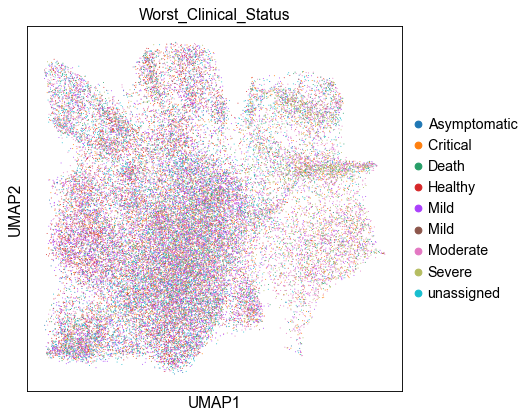

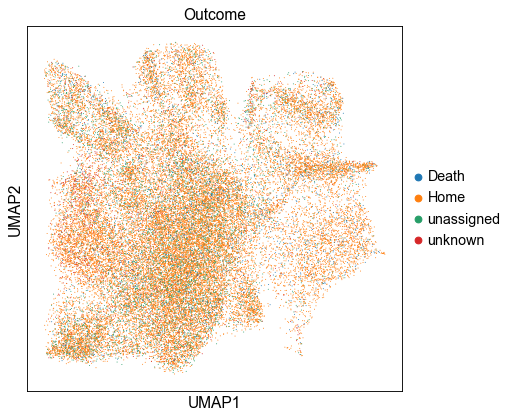

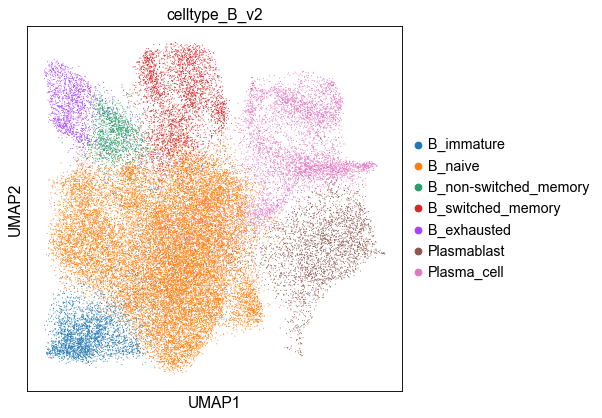

In [22]:
rcParams["figure.figsize"] = (6, 6)
for el in metadata:
    sc.pl.umap(adata, color=el)

In [23]:
adata.obsm['alpha_seq'].shape

(38793, 30)

In [24]:
adata.obsm['beta_seq'].shape

(38793, 30)